In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt

2025-10-03 08:43:49.392059: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-03 08:43:50.049401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = load_model("resnet50_cancer_model-MRI-finetuned-version-1.keras")

2025-10-03 08:43:53.523362: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-03 08:43:53.592010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-03 08:43:53.592050: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-03 08:43:53.595972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-03 08:43:53.596013: I external/local_xla/xla/stream_executor

In [3]:
img_path = "./test-image-MRI/4.jpg"
class_names = ['brain_glioma_tumor', 'brain_meningioma_tumor', 'brain_normal', 'brain_pituitary_tumor', 'kidney_cyst', 'kidney_normal', 'kidney_stone', 'kidney_tumor', 'pancreatic_normal', 'pancreatic_tumor']
# Load and preprocess the image (no normalization)
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)

In [4]:
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]
confidence = np.max(pred)

# Output result
print(f"Predicted class index: {pred_class}")
print(f"Predicted class name: {class_names[pred_class]}")
print(f"Confidence: {confidence:.4f}")

I0000 00:00:1759481138.456283     956 service.cc:145] XLA service 0x773e940147b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759481138.456776     956 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-10-03 08:45:38.552090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-03 08:45:39.240274: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class index: 4
Predicted class name: kidney_cyst
Confidence: 1.0000


I0000 00:00:1759481141.254006     956 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
# Get the last conv layer
last_conv_layer = model.get_layer("conv5_block3_out")

# Get the final output layer (softmax or logits)
output_layer = model.layers[-1]  # assuming it's the last layer

# Build Grad-CAM model using layer tensors
grad_model = Model(
    inputs=model.input,
    outputs=[last_conv_layer.output,
             output_layer.output[0]]
)




In [6]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[pred_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Normalize heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [7]:
# Resize heatmap to match original image
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Reload original image for overlay
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (224, 224))

# Superimpose heatmap onto original image
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)


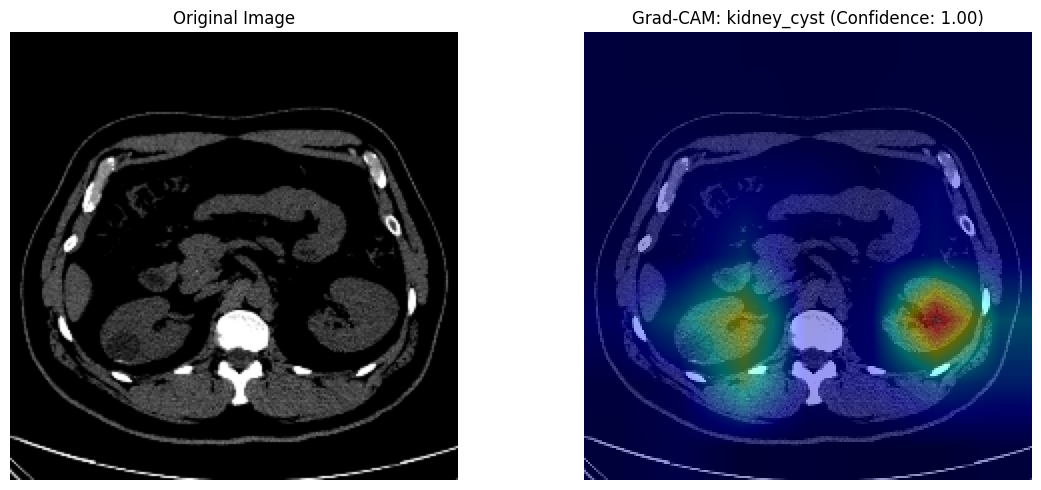

In [8]:
# Reload and resize original image
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (224, 224))
original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Plot both images
plt.figure(figsize=(12, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_rgb)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM overlay
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM: {class_names[pred_class]} (Confidence: {confidence:.2f})")
plt.axis('off')

plt.tight_layout()
plt.show()
